# Tiktok

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import re
from difflib import SequenceMatcher

In [2]:
tt_june = (
    pd.read_csv('DATA/tiktokjune2022.csv')
    .assign(Month='June')
    .rename(columns={
        "Tiktoker": "username",
        "influencer name":"name",
        "Subscribers count": "subs",
        "Views avg.": "views",
        "Likes avg": "likes",
        "Comments avg.": "comments",
        "Shares avg": "shares",
        "Month": "month"
    })
)
tt_june.head(1)

,username,name,subs,views,likes,comments,shares,month
0,___nicoichi___,NICO【平成フラミンゴ】,1.3M,1.9M,225.3K,1.7K,1.1K,June


In [3]:
tt_sep = (
    pd.read_csv('DATA/Tiktoksep2022.csv')
    .assign(Month='September')
    .rename(columns={
        "Tiktoker name": "name",
        "Tiktok name":"username",
        "Subscribers": "subs",
        "Views avg.": "views",
        "Likes avg.": "likes",
        "Comments avg.": "comments",
        "Shares avg.": "shares",
        "Month": "month"
    })
    .drop("S.no", axis=1)
)
tt_sep.head(1)

,name,username,subs,views,likes,comments,shares,month
0,jypestraykids,Stray Kids,13.8M,6.4M,2.3M,50.2K,34.2K,September


In [4]:
tt_nov = (
    pd.read_csv('DATA/tiktoknov2022.csv')
    .assign(Month='November')
    .rename(columns={
        "Tiktoker name": "name",
        "Tiktok name":"username",
        "\nFollowers": "subs",
        "Views (Avg.)": "views",
        "Likes (Avg.)": "likes",
        "Comments (Avg.)": "comments",
        "Shares (Avg.)": "shares",
        "Month": "month"
    })
    .drop("row-cell", axis=1)
    .drop(0)
)
tt_nov.head(1)

,name,username,subs,views,likes,comments,shares,month
1,yossikramer,Yossi,145.6K,26.8M,2.2M,30.1K,71.2K,November


In [5]:
tt_dec = (
    pd.read_csv('DATA/TIKTOKDEC2022.csv')
    .assign(Month='December')
    .rename(columns={
        "Tiktoker name": "name",
        "Tiktok name":"username",
        "followers": "subs",
        "views(avg)": "views",
        "likes(avg.)": "likes",
        "comments(avg.)": "comments",
        "shares(avg.)": "shares",
        "Month": "month"
    })
    .drop("Rank", axis=1)
)
tt_dec.head(1)

,name,username,subs,views,likes,comments,shares,month
0,mrbeast,MrBeast,60.3M,29.2M,3.5M,30.8K,7.2K,December


In [6]:
def cientific_int(column: pd.Series) -> pd.Series:
    return (
        column
        .fillna('0')
        .replace({'K': '*1e3', 'M': '*1e6', 'G':'*1e9'}, regex=True)
        .map(pd.eval)
        .astype(int)
        .replace(0, np.nan)
    )


numeric_text_cols = ['subs', 'views', 'likes', 'comments', 'shares']

tt_june.loc[:, numeric_text_cols] = tt_june[numeric_text_cols].apply(cientific_int)
tt_sep.loc[:, numeric_text_cols] = tt_sep[numeric_text_cols].apply(cientific_int)
tt_nov.loc[:, numeric_text_cols] = tt_nov[numeric_text_cols].apply(cientific_int)
tt_dec.loc[:, numeric_text_cols] = tt_dec[numeric_text_cols].apply(cientific_int)

In [7]:
tt_months = (
    pd.concat([tt_june, tt_sep, tt_nov, tt_dec], ignore_index=True)
    .drop_duplicates()
)

tt_months.head(3)

,username,name,subs,views,likes,comments,shares,month
0,___nicoichi___,NICO【平成フラミンゴ】,1300000.0,1900000.0,225300.0,1700.0,1100.0,June
1,_.anime.edits_0,video,97000.0,1700000.0,75600.0,1500.0,8700.0,June
2,_.respect.boss._,Respect compilation 🤝🥶,1500000.0,4400000.0,241900.0,249.0,797.0,June


# Análisis

## 1. Tenemos 3055 cuentas únicas en nuestros registros de tiktok


In [8]:
tt_months.username.drop_duplicates().size

3055

## 2. Medias de followers, views, likes, comments y shares de cada cuenta

In [9]:
tt_means = (
    tt_months
    .groupby('username')
     # aggregate functiosn skips nan by deffault
    .aggregate({
        'subs': 'mean',
        'views': 'mean',
        'likes': 'mean',
        'comments': 'mean',
        'shares': 'mean'
    })    
    .reset_index()
    .sort_values('subs', ascending=False)
)

In [10]:
tt_means

,username,subs,views,likes,comments,shares
815,Khabane lame,1.514333e+08,1.430000e+07,1.766667e+06,14166.666667,4733.333333
1803,charli d’amelio,1.478667e+08,1.053333e+07,7.970667e+05,12466.666667,3366.666667
2216,khaby.lame,1.432000e+08,2.530000e+07,2.900000e+06,23500.000000,16300.000000
187,Bella Poarch,9.200000e+07,6.700000e+06,5.797500e+05,4850.000000,1300.000000
1716,bellapoarch,9.020000e+07,6.800000e+06,9.219000e+05,9500.000000,1200.000000
...,...,...,...,...,...,...
2736,tedwards,5.100000e+03,9.433000e+05,1.896000e+05,1900.000000,3100.000000
2178,juliaaliceaa,3.700000e+03,2.200000e+06,5.503000e+05,3100.000000,14300.000000
1634,alexbatistao,3.200000e+03,9.517000e+05,4.660000e+04,1700.000000,19400.000000
1671,apollolikesblu,3.000000e+03,7.023000e+05,1.245000e+05,9500.000000,2100.000000


## 3. Métricas de valor

In [11]:
tt_means['views_ratio'] = tt_means.views / tt_means.subs
tt_means['likes_ratio'] = tt_means.likes / tt_means.subs
tt_means['comments_ratio'] = tt_means.comments / tt_means.subs
tt_means['share_ratio'] = tt_means.shares / tt_means.subs

In [12]:
tt_means

,username,subs,views,likes,comments,shares,views_ratio,likes_ratio,comments_ratio,share_ratio
815,Khabane lame,1.514333e+08,1.430000e+07,1.766667e+06,14166.666667,4733.333333,0.094431,0.011666,0.000094,0.000031
1803,charli d’amelio,1.478667e+08,1.053333e+07,7.970667e+05,12466.666667,3366.666667,0.071235,0.005390,0.000084,0.000023
2216,khaby.lame,1.432000e+08,2.530000e+07,2.900000e+06,23500.000000,16300.000000,0.176676,0.020251,0.000164,0.000114
187,Bella Poarch,9.200000e+07,6.700000e+06,5.797500e+05,4850.000000,1300.000000,0.072826,0.006302,0.000053,0.000014
1716,bellapoarch,9.020000e+07,6.800000e+06,9.219000e+05,9500.000000,1200.000000,0.075388,0.010221,0.000105,0.000013
...,...,...,...,...,...,...,...,...,...,...
2736,tedwards,5.100000e+03,9.433000e+05,1.896000e+05,1900.000000,3100.000000,184.960784,37.176471,0.372549,0.607843
2178,juliaaliceaa,3.700000e+03,2.200000e+06,5.503000e+05,3100.000000,14300.000000,594.594595,148.729730,0.837838,3.864865
1634,alexbatistao,3.200000e+03,9.517000e+05,4.660000e+04,1700.000000,19400.000000,297.406250,14.562500,0.531250,6.062500
1671,apollolikesblu,3.000000e+03,7.023000e+05,1.245000e+05,9500.000000,2100.000000,234.100000,41.500000,3.166667,0.700000


## 4. Gráficas del numero de cuentas que inicien por cada letra del alfabeto y agrupar en una categoría todos los que no comiencen con una letra del alfabeto

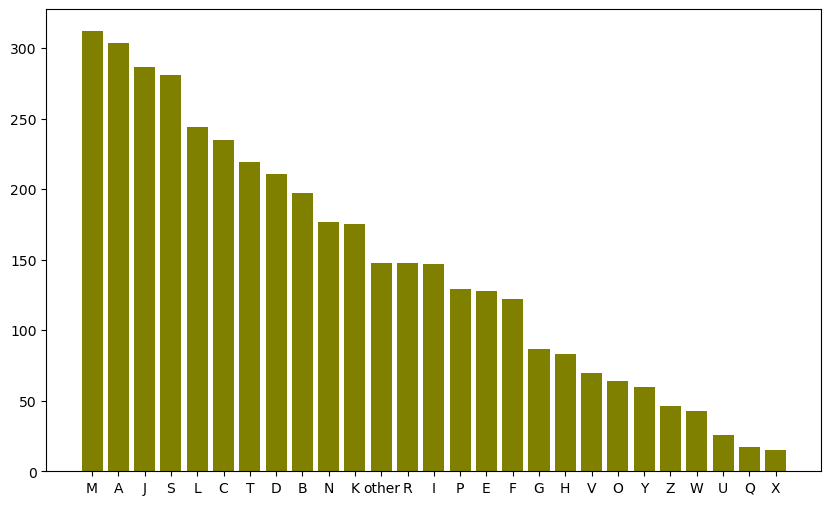

In [13]:
def get_inicial(name: str) -> str:
    name = str(name)
    first_is_letter = re.search(r'^[a-zA-Z]', name)
    if first_is_letter:
        return name[0].upper()
    else:
        return 'other'


initials = (
    tt_months.name
    .map(get_inicial)
    .value_counts()
    .reset_index(name='frequency')
    .rename(columns={
        'index': 'letter',
        'name': 'letter'
    })
)
plt.figure(figsize=(10, 6)) 
plt.bar(initials.letter, initials.frequency, color = 'olive')
plt.show()

## 5. ¿Cual es la cuenta de tiktok con mas caracteres en su nombre?

In [14]:
name_len = (
    tt_months[['name', 'username']]
    .assign(len_name = tt_months.name.map(lambda x: len(str(x))))
    .assign(len_username = tt_months.username.map(lambda x: len(str(x))))
)
tds1 = name_len.loc[name_len.len_name.idxmax()]
tds2 = name_len.loc[name_len.len_username.idxmax()]

In [15]:
tds2

name                               spriteder_spd
username        Prite Netijen Netirattanapaiboon
len_name                                      13
len_username                                  32
Name: 1501, dtype: object

In [16]:
tds1

name            بيسان اسماعيل - Bessan Ismail
username                        bessan_esmail
len_name                                   29
len_username                               13
Name: 116, dtype: object

## 6. Cuántas cuentas de tiktok tienen el nombre del aguno de estos animales: perro, gato, leon tigre?

In [17]:
(tt_months.username.str.contains(r'^(perro|gato|leon|tigre)$') | tt_months.username.str.contains(r'^(perro|gato|leon|tigre)$')).sum()

/tmp/ipykernel_2145/3064001155.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  (tt_months.username.str.contains(r'^(perro|gato|leon|tigre)$') | tt_months.username.str.contains(r'^(perro|gato|leon|tigre)$')).sum()


0

## 7. Defina una metrica que identifique las 10 cuentas más importantes de tiktok

In [18]:
tt_means = (
    tt_means
    .assign(
        engagement_size = (tt_means.views / tt_means.subs) * (tt_means.subs / max(tt_means.subs))
    )
    .sort_values(['views'], ascending=False)
)
tt_means[['username', 'views']].head(10)

,username,views
1335,SehatAQUA,6.110000e+07
1699,badbunny,4.890000e+07
2956,يزن الأسمر,4.890000e+07
1546,Yossi,2.680000e+07
1073,MrBeast,2.676667e+07
2216,khaby.lame,2.530000e+07
1536,Yailin La Más Viral,2.500000e+07
792,Karol G,2.370000e+07
2480,noahschnapp,2.360000e+07
47,Addison Rae,2.200000e+07


## 8. Grafique una serie de tiempo de las cuentas que tengan al menos 3 datos de meses distintos de los promedios obtenidos en el inciso II